# Creating Saliency Maps for CNNs with `LIME`

Return to the [castle](https://github.com/Nkluge-correa/TeenyTinyCastle).

According to "_[The mythos of model interpretability](https://arxiv.org/pdf/1606.03490.pdf)_", these are the properties of an "_interpretable model_": 

> A human can repeat (_"simulatability"_) the computation process with a full understanding of the algorithm (_"algorithmic transparency"_) and every individual part of the model owns an intuitive explanation (_"decomposability"_).

Explainable AI (`XAI`) is an approach to artificial intelligence that aims to achieve this level of interpretability. In it, we seek to create models that are transparent, interpretable, and can provide human-understandable explanations for their decisions or predictions.

The goal of `XAI` is to improve the trustworthiness and reliability of AI systems, as well as to facilitate collaboration between humans and machines. One could even say that `XAI` seeks to help us create a verifiable science of AI. `XAI` techniques include methods for visualizing model internals, feature importance analysis, and rule extraction, among other methods. 

By providing clear and interpretable explanations for the behavior of AI models, these techniques can help us increase the transparency and accountability of these systems, which is particularly important in applications such as healthcare, finance, and law enforcement, where decisions made by AI models can have significant impacts on people's lives. 

`XAI` (specifically in CV applications) has formed two major threads of response: `feature visualization` and `saliency mapping`. This notebook focuses on `saliency mapping` techniques.

![image](https://raw.githubusercontent.com/marcotcr/lime/master/doc/images/images.png)

For a comprehensive explanation of the limitations and difficulties related to saliency mapping techniques, [we recommend this article](https://arxiv.org/abs/2002.00772), made by _[Ahmed Alqaraawi](https://arxiv.org/search/cs?searchtype=author&query=Alqaraawi%2C+A), [Martin Schuessler](https://arxiv.org/search/cs?searchtype=author&query=Schuessler%2C+M), [Philipp Weiß](https://arxiv.org/search/cs?searchtype=author&query=Wei%C3%9F%2C+P), [Enrico Costanza](https://arxiv.org/search/cs?searchtype=author&query=Costanza%2C+E), [Nadia Berthouze](https://arxiv.org/search/cs?searchtype=author&query=Berthouze%2C+N)_.

For a complete guide on ML Explainability, we recommend "_[Interpretable Machine Learning: A Guide for Making Black Box Models Explainable](https://christophm.github.io/interpretable-ml-book/)_" (by _[Christoph Molnar](https://christophmolnar.com/)_).

In this notebook, we will be interpreting a CNN trained on the _Cats vs Dogs dataset_, i.e., [a large set of images of cats and dogs](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs).

The training of a CNN is outside the scope of this notebook. So, we are just gonna upload a pre-trained model. You can find loads of tutorials on how to train a CNN in the literature, like in [_Deep Learning with Python_](https://tanthiamhuat.files.wordpress.com/2018/03/deeplearningwithpython.pdf), and in this [notebook](https://github.com/Nkluge-correa/TeenyTinyCastle/blob/fa17764aa8800c388d0d298b750c686757e0861e/ML-Explainability/CV/CNN_model_maker.ipynb).

If you do not want to train the model, you can load the trained version in the cell below. But first, you need to download them (instructions in the `models` folder.)


In [1]:
import tensorflow as tf

model = tf.keras.models.load_model('models/cats_vs_dogs.h5')
model.trainable = False

To visualize the arquitecture of a neural network, if you are using `Keras`, you can use the `visualkeras` package.

```python

visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show() # write and show

```


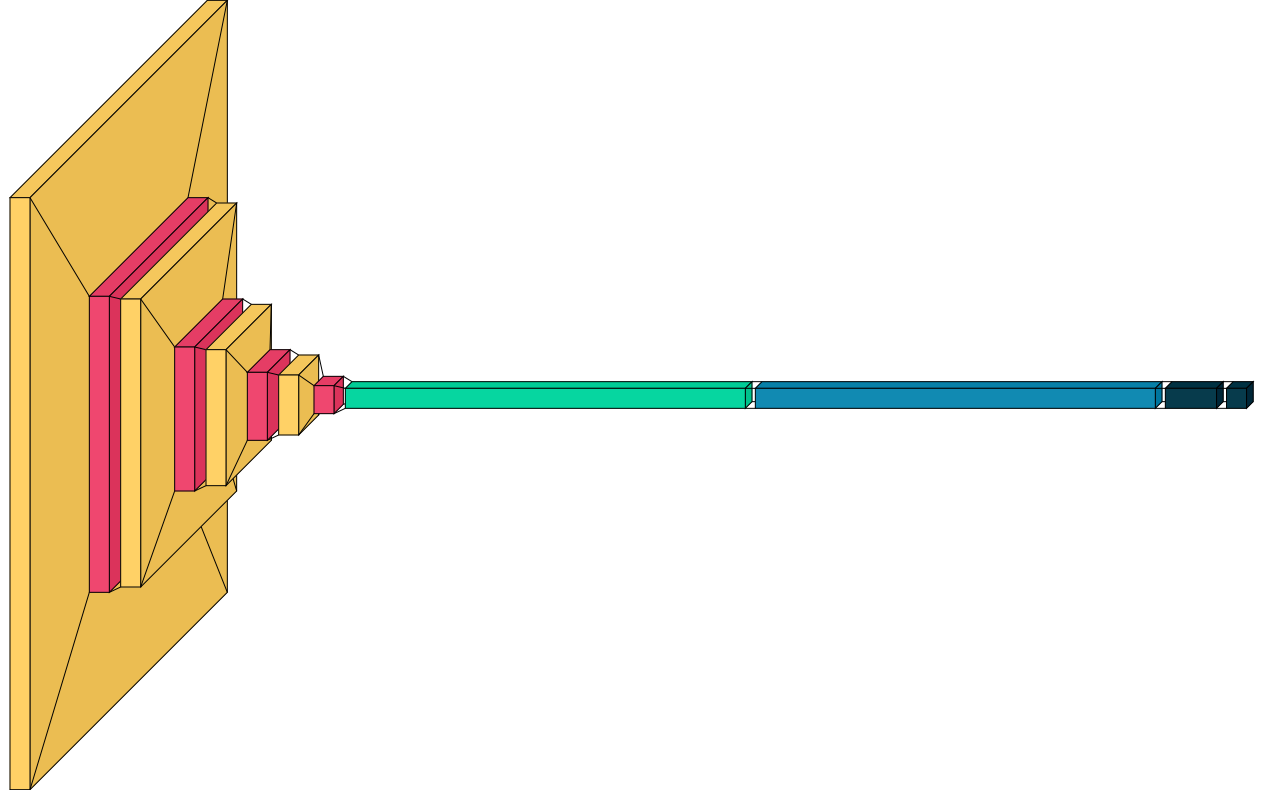

In [2]:
import visualkeras

visualkeras.layered_view(model)

Let's now test our classification with some images. This CNN was trained with a `sigmoid` output function. Thus we created a custom fuction to get our `class_label`, `class_name`, and `class_confidence`.

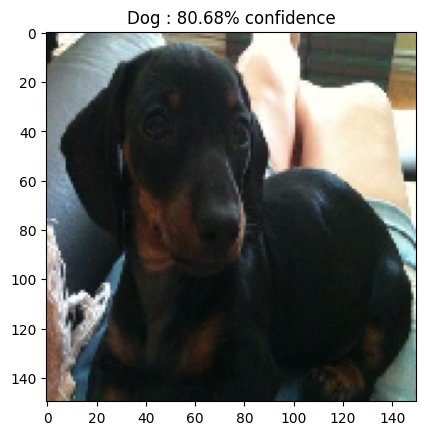

In [3]:
import numpy as np
import matplotlib.pyplot as plt

#img_path = r'samples/cat.jpg'
img_path = r'samples/tucassauros.jpg'

img = tf.keras.utils.load_img(img_path, target_size=(150, 150))
img_tensor = tf.keras.utils.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.


def get_image_label(img_tensor):
    """
    Returns the class of the image and the confidence of the prediction

    Parameters
    ----------
    img_tensor : numpy.ndarray
        The image tensor
    
    Returns
    -------
    image_class : int
        The class of the image
    class_name : str
        The name of the class   
    class_confidence : float
        The confidence of the prediction
    """
    prediction = model.predict(img_tensor, verbose=0)

    if prediction[0][0] <= 0.5:
        class_label = 0
        class_name = 'Cat'
        class_confidence = (1 - prediction[0][0]) * 100
        return class_label, class_name, class_confidence
    else:
        class_label = 1
        class_name = 'Dog'
        class_confidence = prediction[0][0] * 100
        return class_label, class_name, class_confidence


plt.figure()
plt.imshow(img_tensor[0])
image_class, class_name, class_confidence = get_image_label(img_tensor)
plt.title('{} : {:.2f}% confidence'.format(class_name, class_confidence))
plt.axis('off')
plt.show()

To help us arrive at an understanding of the "_why_" of this classification, we will use the `LIME` methodology. 🔎

### Local Interpretable Model-agnostic Explanations

[`LIME`](https://arxiv.org/abs/1602.04938?context=cs) is an interpretability methodology proposed by [Marco Tulio Ribeiro](https://arxiv.org/search/cs?searchtype=author&query=Ribeiro%2C+M+T), [Sameer Singh](https://arxiv.org/search/cs?searchtype=author&query=Singh%2C+S), and [Carlos Guestrin](https://arxiv.org/search/cs?searchtype=author&query=Guestrin%2C+C).

The key idea behind it is to locally approximate a black-box model by a simpler glass-box model, which is easier to interpret. The method has been widely adopted in the text and image analysis, partly due to the interpretable data representation.

![image](https://c3.ai/wp-content/uploads/2020/10/Lime1-500x270.png)

Source: _["Why Should I Trust You?": Explaining the Predictions of Any Classifier](https://arxiv.org/abs/1602.04938?context=cs)_.

To create an "_explainer_" with `LIME`, we need to pass the following parameters:

- `images`: _the image that we want LIME to explain._
- `classifier`: _your image classier prediction function._
- `top_labels`: _the number of labels that you want LIME to show (2 will show Top 2)._
- `num_samples`: _the amount of artificial samples that we will feed to the surrogate interpretable model._

In [ ]:
from lime import lime_image

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(img_tensor[0].astype('double'), model.predict,
                                         top_labels=2, hide_color=0, num_samples=1000)


The object created (`explanation`) has a method called `get_image_and_mask`, capable of generating an explanation (based on saliency maps) of the classification in question.

(-0.5, 149.5, 149.5, -0.5)

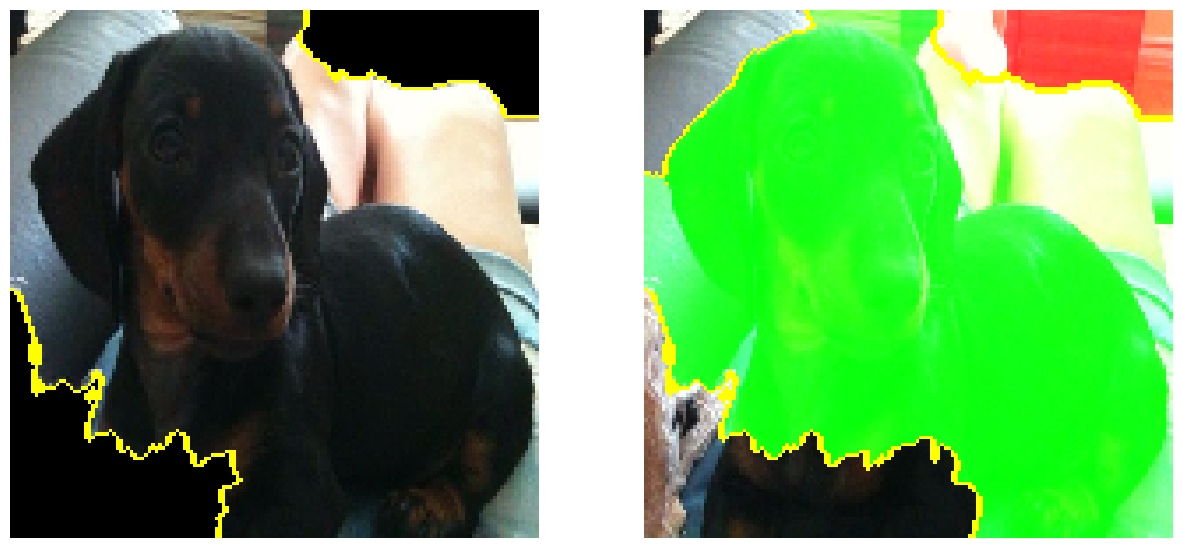

In [5]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0],
                                                positive_only=True,
                                                num_features=10,
                                                hide_rest=True)

temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0],
                                                positive_only=False,
                                                num_features=10,
                                                hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')


- On the left image (`ax1`), we can see that only the super-pixels where "_cat-features_" are visible are shown. This means that our model classifies our image as a cat because of these parts of super-pixels

- On the right image (`ax2`), the area of super-pixels colored in green are the ones that increase the probability of our image belonging to the Cat class, while the super-pixels colored in red are the ones that decrease the probability.

Let's test this tool on another model!

## `MobileNetV2`

`MobileNetV2` is a convolutional neural network architecture that seeks to perform well on mobile devices. It is based on an inverted residual structure where the residual connections are between the bottleneck layers. The intermediate expansion layer uses lightweight depthwise convolutions to filter features as a source of non-linearity. Overall, the architecture of MobileNetV2 contains the initial fully [convolution](https://paperswithcode.com/method/convolution) layer with 32 filters, followed by 19 residual bottleneck layers.

![image](https://www.researchgate.net/publication/350152088/figure/fig1/AS:1002717703045121@1616077938892/The-proposed-MobileNetV2-network-architecture.png)

You can load this model directly from the (TF)Keras API, weights, and all! 🙃

14536120/14536120 [==============================] - 2s 0us/step


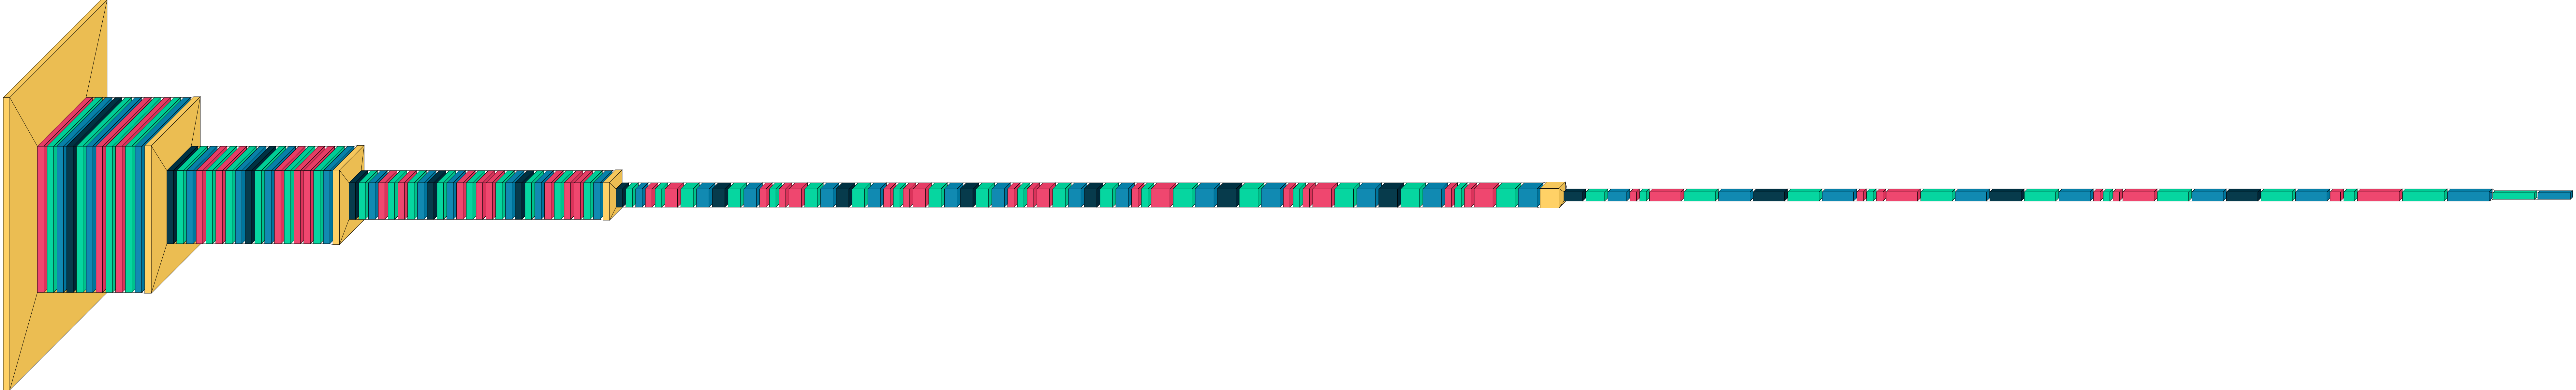

In [6]:
model = tf.keras.applications.MobileNetV2(include_top=True,
                                          weights='imagenet')
model.trainable = False

visualkeras.layered_view(model)

Let's now test `MobileNetV2` with something less cute than cats and dogs...

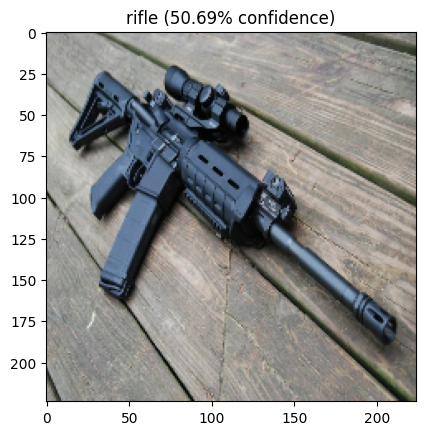

In [8]:
img_path = r'samples/rifle.jpg'

def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    image = image[None, ...]
    return image


def get_imagenet_label(probs):
    return tf.keras.applications.mobilenet_v2.decode_predictions(probs, top=1)[0][0]


image_raw = tf.io.read_file(img_path)
img = tf.image.decode_image(image_raw)
img = preprocess(img)
image_probs = model.predict(img, verbose=0)
class_index = np.argmax(image_probs[0])

plt.figure()
plt.imshow(img[0] * 0.5 + 0.5)
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} ({:.2f}% confidence)'.format(image_class, class_confidence*100))
plt.show()


Now, we will use the same method that we used before.

(-0.5, 223.5, 223.5, -0.5)

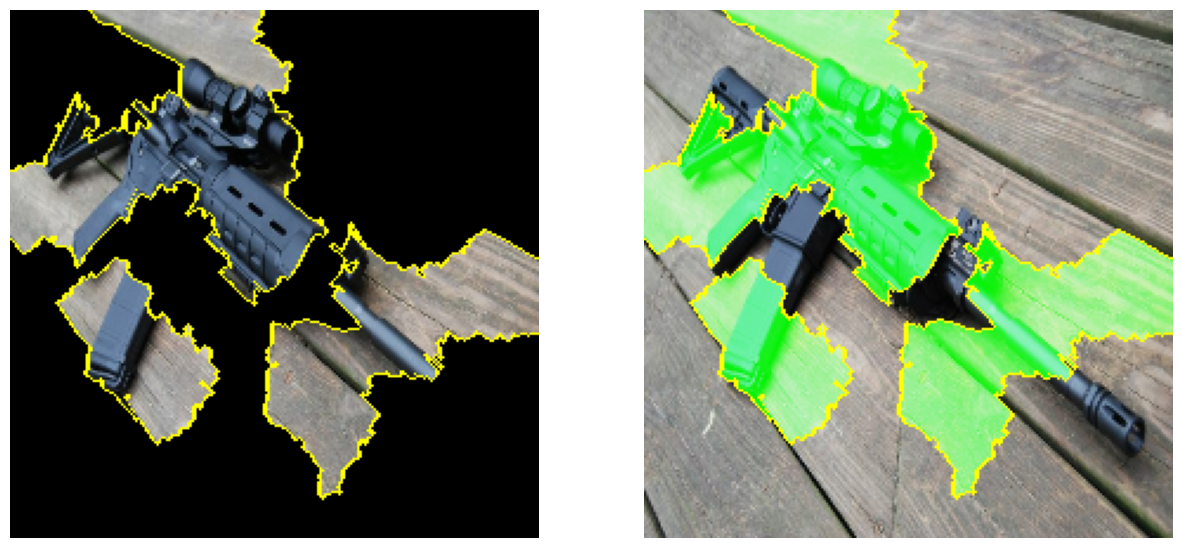

In [10]:
explainer = lime_image.LimeImageExplainer()


explanation = explainer.explain_instance((np.array(img)[0] * 0.5 + 0.5).astype('double'), model.predict,
                                         top_labels=10, hide_color=0, num_samples=1000)

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0],
                                                positive_only=True,
                                                num_features=10,
                                                hide_rest=True)

temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0],
                                                positive_only=False,
                                                num_features=10,
                                                hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')


The LIME methodology is a useful tool for developers seeking to understand and explain the behavior of black-box models. And now you know how to use LIME in CV applications.

---

Return to the [castle](https://github.com/Nkluge-correa/TeenyTinyCastle).
